# 1. Load the data

In [1]:
import pandas as pd

df = pd.read_pickle("final_data.pkl")

# Set some pandas options for viewing datasets
pd.set_option("display.max_columns", None)
pd.options.mode.chained_assignment = None


# df[df['name'] == 'Erling Haaland'].head()

In [3]:
# Restrict the columns

df_anad = df[
    [
        "name",
        "position",
        "team",
        "GW",
        "total_points",
        "goals_scored",
        "assists",
        "goals_conceded",
        "saves",
        "ict_index",
        "minutes",
        "transfers_in",
        "value",
        "was_home",
        "fix_difficulty",
        "selected"
    ]
]

# Only select players who played at least 30 minutes

df_anad_no0 = df_anad[
    (df_anad["minutes"] > 30)
]

# 2. Descriptive statistics

In [10]:
descriptive_stats = df_anad_no0.describe().transpose()
descriptive_stats

,count,mean,std,min,25%,50%,75%,max
GW,8582.0,19.405150,1.099990e+01,1.0,10.0,19.0,29.00,38.0
total_points,8582.0,3.273596,3.317689e+00,-4.0,1.0,2.0,5.00,29.0
goals_scored,8582.0,0.126544,3.811448e-01,0.0,0.0,0.0,0.00,4.0
assists,8582.0,0.112911,3.537123e-01,0.0,0.0,0.0,0.00,4.0
goals_conceded,8582.0,1.487765,1.302522e+00,0.0,1.0,1.0,2.00,8.0
saves,8582.0,0.290142,1.158942e+00,0.0,0.0,0.0,0.00,15.0
ict_index,8582.0,4.434130,3.764783e+00,0.0,1.9,3.2,5.80,32.6
minutes,8582.0,83.351084,2.019663e+01,31.0,77.0,90.0,90.00,180.0
transfers_in,8582.0,39340.570613,1.013250e+05,0.0,760.5,5360.0,29619.50,1689375.0
value,8582.0,52.320438,1.242843e+01,36.0,45.0,49.0,55.00,145.0


# 3. ANOVA

In [4]:
# ANOVA
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Group data by position
grouped_data = [
    df_anad_no0[df_anad_no0["position"] == pos]["total_points"]
    for pos in df_anad_no0["position"].unique()
]

# 1. Check Normality (Shapiro-Wilk test)
for pos, data in zip(df_anad_no0["position"].unique(), grouped_data):
    stat, p = stats.shapiro(data)
    print(f"Shapiro-Wilk test for {pos}: p-value = {p:.5f}")

# 2. Check Homogeneity of Variance (Levene's test)
levene_stat, levene_p = stats.levene(*grouped_data)
print(f"\nLevene's test for homogeneity of variance: p-value = {levene_p:.5f}")

# 3. Perform One-Way ANOVA
anova_stat, anova_p = stats.f_oneway(*grouped_data)
model = ols("total_points ~ C(position)", data=df_anad_no0).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print("ANOVA Table:")
print(anova_table)
print(f"\nANOVA result: F-statistic = {anova_stat:.5f}, p-value = {anova_p:.5f}")

# 4. If ANOVA is significant, perform post-hoc Tukey's HSD test
if anova_p < 0.05:
    print("\nANOVA is significant. Performing Tukey HSD test...")
    tukey = pairwise_tukeyhsd(df_anad_no0["total_points"], df_anad_no0["position"])
    print(tukey)

Shapiro-Wilk test for DEF: p-value = 0.00000
Shapiro-Wilk test for GK: p-value = 0.00000
Shapiro-Wilk test for MID: p-value = 0.00000
Shapiro-Wilk test for FWD: p-value = 0.00000

Levene's test for homogeneity of variance: p-value = 0.00000
ANOVA Table:
                   sum_sq      df         F        PR(>F)
C(position)   1828.696121     3.0  56.45312  3.954518e-36
Residual     92622.900710  8578.0       NaN           NaN

ANOVA result: F-statistic = 56.45312, p-value = 0.00000

ANOVA is significant. Performing Tukey HSD test...
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
   DEF    FWD   1.4163    0.0  1.0997   1.733   True
   DEF     GK    0.569 0.0001  0.2258  0.9122   True
   DEF    MID   0.7689    0.0  0.5653  0.9725   True
   FWD     GK  -0.8473    0.0 -1.2636 -0.4309   True
   FWD    MID  -0.6474    0.0 -0.9589 -0.3359   True
    GK    MID   0.1999  0.427 -0.1386  

In [5]:
# Calculate effect size (Eta Squared)
eta_squared = anova_table["sum_sq"]["C(position)"] / (
    anova_table["sum_sq"]["C(position)"] + anova_table["sum_sq"]["Residual"]
)
print(f"Effect Size (Eta Squared): {eta_squared:.5f}")

Effect Size (Eta Squared): 0.01936


# 3b. Data visualization - ANOVA

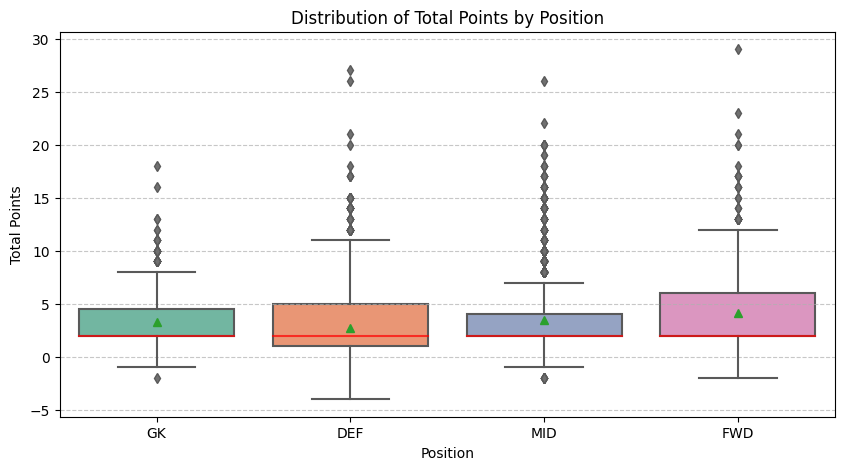

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

# Boxplot Visualization
plt.figure(figsize=(10, 5))
sns.boxplot(
    x="position",
    y="total_points",
    data=df_anad_no0,
    palette="Set2",
    order=["GK", "DEF", "MID", "FWD"],
    showmeans=True,
    medianprops=dict(color="red", alpha=0.7),
    flierprops=dict(markerfacecolor="#707070", marker="d"),
)
plt.title("Distribution of Total Points by Position")
plt.xlabel("Position")
plt.ylabel("Total Points")
plt.grid(axis="y", linestyle="--", alpha=0.7)
# plt.ylim(-5, 15)
plt.show()

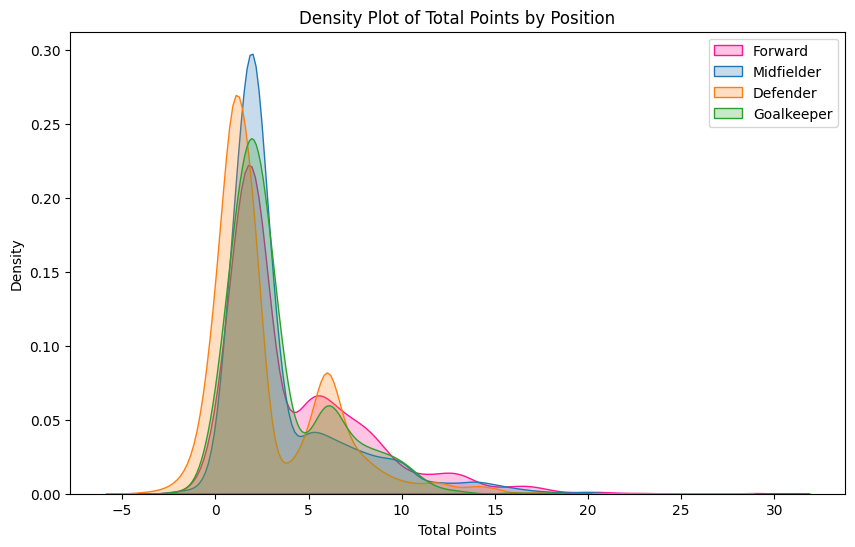

In [7]:
plt.figure(figsize=(10, 6))
sns.kdeplot(
    df_anad_no0[df_anad_no0["position"] == "FWD"]["total_points"],
    label="Forward",
    fill=True,
    color='deeppink'
)
sns.kdeplot(
    df_anad_no0[df_anad_no0["position"] == "MID"]["total_points"],
    label="Midfielder",
    fill=True,
)
sns.kdeplot(
    df_anad_no0[df_anad_no0["position"] == "DEF"]["total_points"],
    label="Defender",
    fill=True,
)
sns.kdeplot(
    df_anad_no0[df_anad_no0["position"] == "GK"]["total_points"],
    label="Goalkeeper",
    fill=True,
)
plt.title("Density Plot of Total Points by Position")
plt.xlabel("Total Points")
plt.ylabel("Density")
plt.legend()
plt.show()

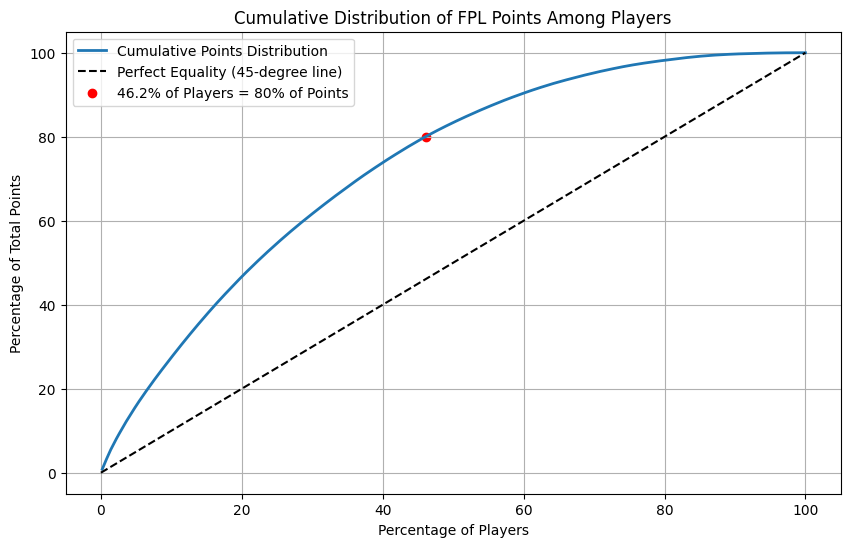

The top 46.2% of players accumulate 80% of total points.


In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate total points per player
player_points = df_anad_no0.groupby("name")["total_points"].sum().reset_index()

# Sort players by total points (descending)
player_points = player_points.sort_values(
    by="total_points", ascending=False
).reset_index(drop=True)

# Calculate cumulative sum of points and total points in dataset
player_points["cumulative_points"] = player_points["total_points"].cumsum()
total_points = player_points["total_points"].sum()

# Calculate cumulative percentage of total points
player_points["cumulative_percentage"] = (
    player_points["cumulative_points"] / total_points * 100
)

# Calculate percentage of players
player_points["player_percentage"] = (
    (player_points.index + 1) / len(player_points) * 100
)

# Plot Lorenz curve (Pareto distribution of points)
plt.figure(figsize=(10, 6))
plt.plot(
    player_points["player_percentage"],
    player_points["cumulative_percentage"],
    label="Cumulative Points Distribution",
    linewidth=2,
)
plt.plot(
    [0, 100], [0, 100], "k--", label="Perfect Equality (45-degree line)"
)  # Reference for equality
plt.xlabel("Percentage of Players")
plt.ylabel("Percentage of Total Points")
plt.title("Cumulative Distribution of FPL Points Among Players")
plt.legend()
plt.grid(True)

# Find the % of players that accumulate 80% of total points
top_80_threshold = player_points[player_points["cumulative_percentage"] >= 80].iloc[0][
    "player_percentage"
]

# Annotate the 80% threshold point on the graph
plt.scatter(
    top_80_threshold,
    80,
    color="red",
    label=f"{top_80_threshold:.1f}% of Players = 80% of Points",
)
plt.legend()
plt.show()

print(f"The top {top_80_threshold:.1f}% of players accumulate 80% of total points.")

# 4. Linear Regression (OLS)

In [10]:
import statsmodels.api as sm

df_anad_no0["was_home"] = df_anad_no0["was_home"].replace("NA", np.nan)
df_anad_no0 = df_anad_no0.dropna()
df_anad_no0["was_home"] = df_anad_no0["was_home"].apply(int)

# Selecting numeric predictors
numeric_features = [
    "goals_scored",
    "assists",
    "goals_conceded",
    "saves",
    "minutes",
    "value",
    "fix_difficulty",
]
binary_feature = "was_home"

# Creating the regression dataset
df_reg = df_anad_no0[
    numeric_features + ["total_points"]
].dropna()

# Defining predictors (X) and target variable (y)
X = df_reg[numeric_features]
y = df_reg["total_points"]

# Adding constant term for intercept
X = sm.add_constant(X)

# Fitting the linear regression model
model = sm.OLS(y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           total_points   R-squared:                       0.802
Model:                            OLS   Adj. R-squared:                  0.802
Method:                 Least Squares   F-statistic:                     4779.
Date:                Sun, 16 Mar 2025   Prob (F-statistic):               0.00
Time:                        13:59:23   Log-Likelihood:                -14660.
No. Observations:                8256   AIC:                         2.934e+04
Df Residuals:                    8248   BIC:                         2.939e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.5586      0.114      4.

# 5b. Data visualization - regression

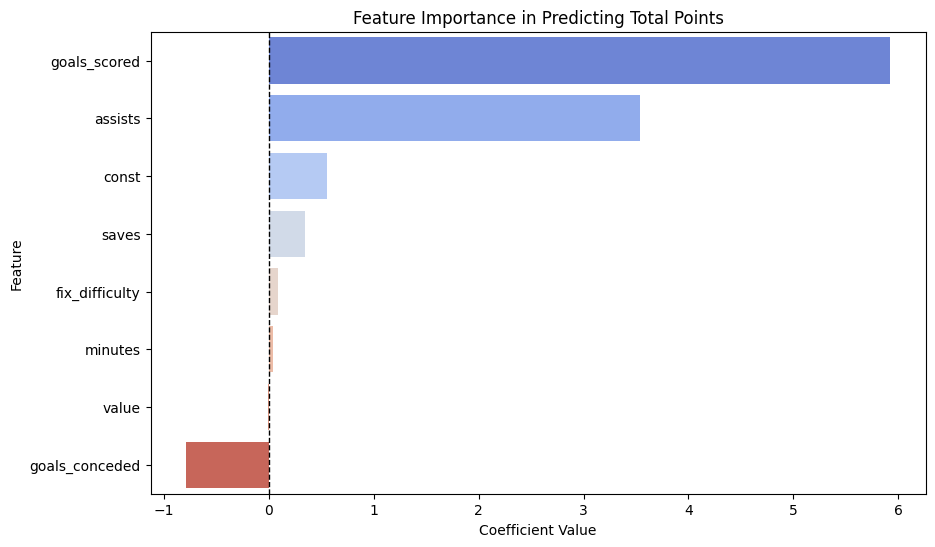

In [11]:
import seaborn as sns

# Extract coefficients and their labels
coef_df = pd.DataFrame({"Feature": X.columns, "Coefficient": model.params})
coef_df = coef_df.sort_values(by="Coefficient", ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x="Coefficient", y="Feature", data=coef_df, palette="coolwarm")
plt.title("Feature Importance in Predicting Total Points")
plt.xlabel("Coefficient Value")
plt.ylabel("Feature")
plt.axvline(x=0, color='black', linestyle='--', linewidth=1)
plt.show()

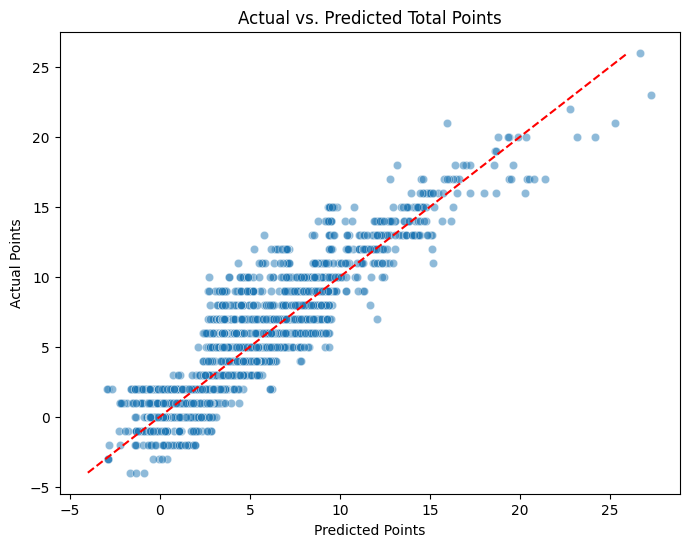

In [12]:
y_pred = model.predict(X)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_pred, y=y, alpha=0.5)
plt.plot([min(y), max(y)], [min(y), max(y)], 'r--')  # Perfect prediction line
plt.xlabel("Predicted Points")
plt.ylabel("Actual Points")
plt.title("Actual vs. Predicted Total Points")
plt.show()


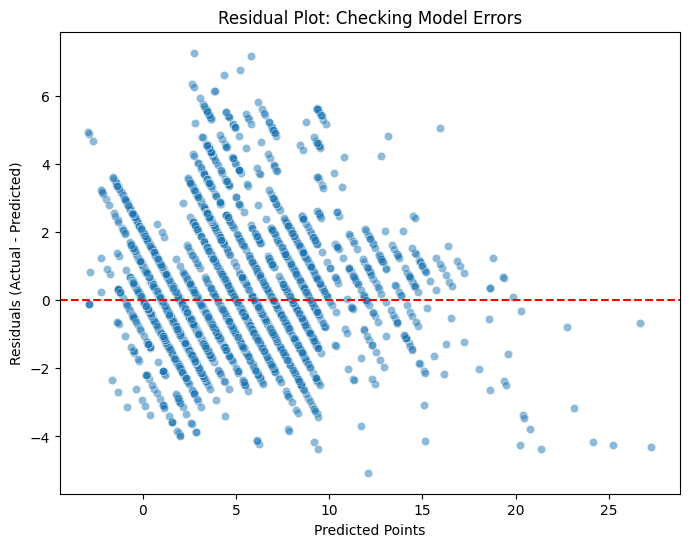

In [13]:
residuals = y - y_pred

plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_pred, y=residuals, alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel("Predicted Points")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title("Residual Plot: Checking Model Errors")
plt.show()


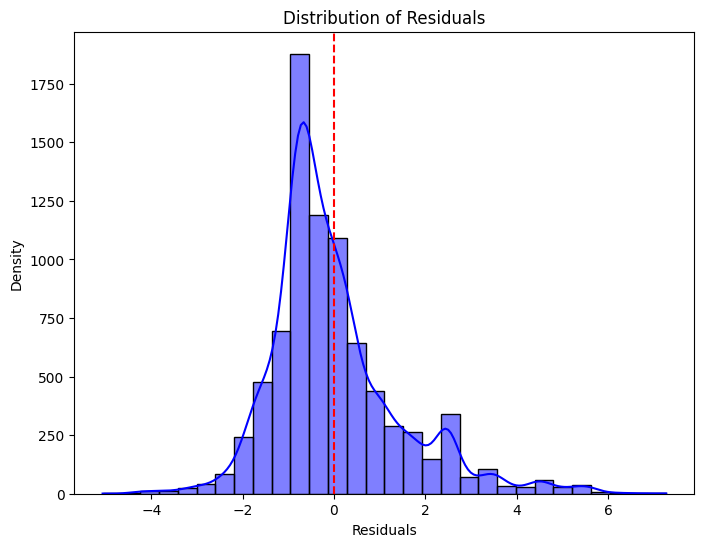

In [14]:
plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True, bins=30, color="blue")
plt.axvline(x=0, color='red', linestyle='--')
plt.xlabel("Residuals")
plt.ylabel("Density")
plt.title("Distribution of Residuals")
plt.show()

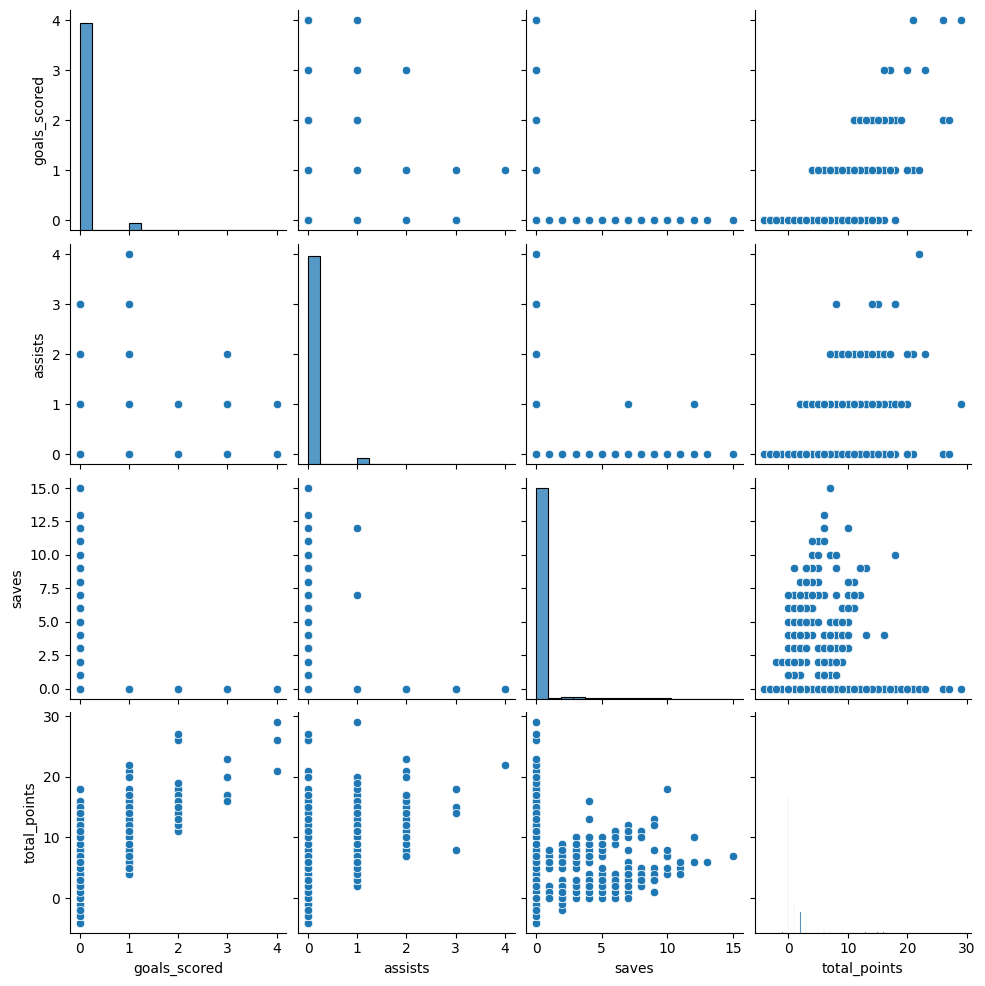

In [15]:
sns.pairplot(df_anad, vars=["goals_scored", "assists", "saves", "total_points"])
plt.show()

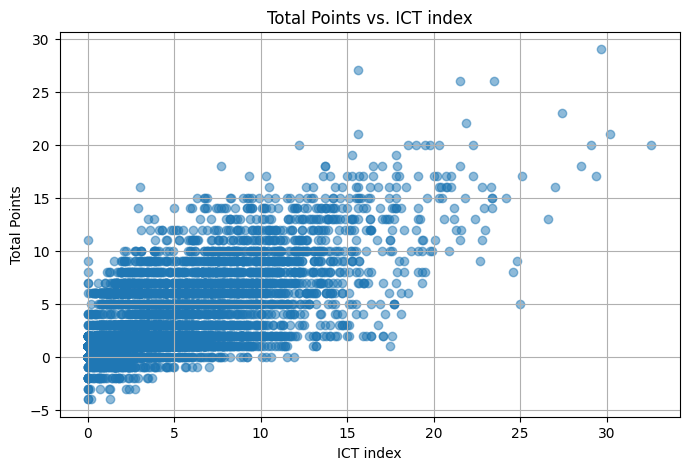

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

# Scatter plot
plt.figure(figsize=(8, 5))
plt.scatter(df_anad["ict_index"], df_anad["total_points"], alpha=0.5)
plt.xlabel("ICT index")
plt.ylabel("Total Points")
plt.title("Total Points vs. ICT index")
plt.grid(True)
plt.show()

In [ ]:
# Export to csv
df_anad_no0.to_csv('final_data.csv', index=False, header='True', encoding='utf-8-sig')